# Heat-Balance Equation — Validation & Visualisation

This notebook validates the steady-state heat-balance solver from
`utils/heat_flow_utils.py` and visualises key thermal relationships for
overhead conductors.

**Contents**

| Section | Description |
|---------|-------------|
| 1 | Imports |
| 2 | Conductor & weather definitions |
| 3 | Plotting helpers |
| 4 | IEEE Std 738-2012 — detailed contour analysis |
| 5 | Quadratic approximation error |
| 6–9 | Comparison plots across conductor models |
| 10 | Standalone legends |
| 11 | Generator derating curves |

Two conductor families are tested:
- **IEEE Drake ACSR** (795 kcmil 26/7, single conductor)
- **European Al/St 240/40** (4-bundle, 380 kV) — with and without
  convective / radiative correction factors, plus a merged-tube
  equivalent

## 1. Imports

In [50]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

sys.path.append(os.path.join(os.getcwd(), ".."))
from data_config import *
from utils.heat_flow_utils import *

sns.set_style('white')

## 2. Conductor & Weather Definitions

### 2.1 IEEE Drake ACSR — IEEE Std 738-2012 Defaults

In [51]:
# 795 kcmil 26/7 Drake ACSR conductor — default parameters from
# IEEE Std 738-2012, Table 1 / Annex examples.
ieee_conductor = {
    'diameter': 28.1e-3,           # m
    'num_bundle': 1,
    'ref_temperature': 25,         # deg-C
    'max_temperature': 90,         # deg-C
    'resistance_ratio': 0.00429,   # Ohm/deg-C
    'unit_resistance': 7.283e-5,   # Ohm/m
    'conductor_angle': 0.0,
    'elevation': 100,              # m
    'inom': 1000,                  # A (nominal rating)
}

ieee_weather = {
    'wind_speed': 0.61,            # m/s
    'wind_angle': np.array([90]),  # degree
    'air_density': 1.029,          # kg/m^3
    'air_viscosity': 2.043e-5,     # kg/(m-s)
    'air_conductivity': 0.02945,   # W/(m-deg-C)
    'air_temperature': 30,         # deg-C
    'radiation_emissivity': 0.8,
    'solar_absorptivity': 0.8,
    'solar_heat_intensity': 1000,  # W/m^2  (IEEE 738 default)
    'wind_height': 50,             # m
}

### 2.2 European Al/St 240/40 (4-bundle, 380 kV)

In [53]:
european_weather = {
    'wind_speed': 0.61,             # m/s
    'wind_angle': np.array([90]),  # degree
    'air_density': 1.029,          # kg/m^3
    'air_viscosity': 2.043e-5,     # kg/(m-s)
    'air_conductivity': 0.02945,   # W/(m-deg-C)
    'air_temperature': 30,         # deg-C
    'radiation_emissivity': 0.8,
    'solar_absorptivity': 0.8,
    'solar_heat_intensity': 900,   # W/m^2
    'wind_height': 50,             # m
}

# Per-sub-conductor parameters (no correction factors)
european_conductor_single = {
    'diameter': 18.881e-3,         # m  (sqrt((240+40)/pi) * 2)
    'num_bundle': 4,
    'ref_temperature': 20.0,       # deg-C
    'max_temperature': 90.0,       # deg-C
    'resistance_ratio': 0.00429,   # Ohm/deg-C
    'unit_resistance': 0.03e-3 * 4,  # Ohm/m (4-bundle)
    'conductor_angle': 0,
    'elevation': 0,
    'inom': 2580 / 4,              # A per sub-conductor
}

# Same, with convective / radiative correction factors
european_conductor_corrected = {
    **european_conductor_single,
    'convective_correction': 0.8,
    'radiactive_correction': 0.8,
}

# Equivalent merged conductor (single-tube approximation)
european_conductor_merge = {
    'diameter': 18.881e-3 * 2.5,   # m (equivalent diameter)
    'num_bundle': 1,
    'ref_temperature': 20.0,       # deg-C
    'max_temperature': 90.0,       # deg-C
    'resistance_ratio': 0.00429,   # Ohm/deg-C
    'unit_resistance': 0.03e-3,    # Ohm/m
    'conductor_angle': 0,
    'elevation': 50,
    'inom': 2580,                  # A total
}

## 3. Plotting Helpers

### 3.1 Contour-label helper

Inline contour labels are positioned at the horizontal midpoint of each
contour path. The helper below extracts these positions so that
`ax.clabel(..., manual=positions)` places labels neatly.

In [59]:
def get_contour_label_positions(contour_set):
    """Return midpoint positions for inline contour labels.

    Parameters
    ----------
    contour_set : matplotlib.contour.QuadContourSet
        The contour set returned by ``ax.contour()``.

    Returns
    -------
    list of array-like
        (x, y) positions suitable for ``ax.clabel(manual=...)``.
    """
    # matplotlib >= 3.8: ContourSet is itself a Collection, use get_paths()
    # matplotlib <  3.8: paths live inside .collections
    try:
        paths = contour_set.get_paths()
    except AttributeError:
        paths = [p for c in contour_set.collections for p in c.get_paths()]

    positions = []
    for path in paths:
        verts = path.vertices
        if len(verts) == 0:
            continue
        mid_x = (verts[:, 0].max() + verts[:, 0].min()) / 2
        mid_idx = np.argmin(np.abs(verts[:, 0] - mid_x))
        positions.append(verts[mid_idx, :])
    return positions

### 3.2 Comparison plot functions

Three reusable functions produce clean contour figures used in
Sections 6–9 to compare conductor models side by side.

| Plot | X-axis | Y-axis | Contour | Key lines |
|------|--------|--------|---------|-----------|
| 1 | Air temp (°C) | Current (A) | Conductor temp (°C) | Thermal limit 90 °C, nominal current |
| 2 | Air temp (°C) | Wind speed (m/s) | Max allowable current (A) | Nominal current |
| 3 | Air temp (°C) | Wind speed (m/s) | Conductor temp (°C) | Thermal limit 90 °C |

In [72]:
THERMAL_LIMIT_COLOR = 'red'
NOMINAL_CURRENT_COLOR = 'blue'


def plot_current_vs_air_temp(conductor=None, weather=None, save_path=None):
    """Contour plot: air temperature x current -> conductor temperature."""
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.6))

    nominal_current = conductor.get('inom', 1000)
    current_list = np.arange(nominal_current * 0.5, nominal_current * 1.1, 1)
    tem_air_list = np.arange(25, 51, 0.5)

    tem_con_list = []
    for t_air in tem_air_list:
        weather['air_temperature'] = np.array([t_air])
        tem_con_list.append(
            heat_banlance_equation(current_list, conductor, weather)
        )
    tem_con_list = np.stack(tem_con_list, axis=1)

    x, y = np.meshgrid(tem_air_list, current_list * conductor['num_bundle'])
    contourf = ax.contourf(x, y, tem_con_list, 15, cmap='coolwarm', alpha=0.95)

    # Reference lines
    if 'inom' in conductor:
        ax.axhline(
            y=conductor['inom'] * conductor['num_bundle'],
            color=NOMINAL_CURRENT_COLOR, linewidth=2.5,
        )
    ax.contour(x, y, tem_con_list, levels=[90],
               colors=THERMAL_LIMIT_COLOR, linewidths=2.5)

    ax.set_xlabel('Air Temperature (°C)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Conductor Current (A)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(contourf, ax=ax)
    cbar.set_label('Conductor Temperature (°C)', fontsize=16, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=500, bbox_inches='tight')
    return fig, ax


def plot_max_current_vs_conditions(conductor=None, weather=None, save_path=None):
    """Contour plot: air temperature x wind speed -> max allowable current."""
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.6))

    tem_air_list = np.arange(25, 51, 0.5)
    wind_speed_list = np.arange(0.6, 4, 0.05)

    I_max_list = []
    weather['wind_speed'] = wind_speed_list
    for t_air in tem_air_list:
        weather['air_temperature'] = t_air
        Imax = (maximum_allowable_current(conductor.copy(), weather.copy())
                * conductor['num_bundle'])
        I_max_list.append(Imax)
    I_max_list = np.stack(I_max_list, axis=1)

    x, y = np.meshgrid(tem_air_list, wind_speed_list)
    contourf = ax.contourf(x, y, I_max_list, 15, cmap='viridis', alpha=0.95)

    ax.contour(
        x, y, I_max_list,
        levels=[conductor['inom'] * conductor['num_bundle']],
        colors=NOMINAL_CURRENT_COLOR, linewidths=2.5,
    )

    ax.set_xlabel('Air Temperature (°C)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Wind Speed (m/s)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(contourf, ax=ax)
    cbar.set_label('Maximum Current (A)', fontsize=16, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=500, bbox_inches='tight')
    return fig, ax


def plot_temp_vs_conditions_at_nominal(conductor=None, weather=None,
                                       save_path=None):
    """Contour plot: air temperature x wind speed -> conductor temp at I_nom."""
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.6))

    tem_air_list = np.arange(25, 51, 0.5)
    wind_speed_list = np.arange(0.6, 4, 0.01)

    tem_con_list = []
    current = conductor['inom']
    weather['air_temperature'] = tem_air_list
    for ws in wind_speed_list:
        weather['wind_speed'] = ws
        tem_con_list.append(
            heat_banlance_equation(current, conductor.copy(), weather.copy())
        )
    tem_con_list = np.stack(tem_con_list, axis=0)

    x, y = np.meshgrid(tem_air_list, wind_speed_list)
    contourf = ax.contourf(x, y, tem_con_list, 15, cmap='coolwarm', alpha=0.95)

    ax.contour(x, y, tem_con_list, levels=[90],
               colors=THERMAL_LIMIT_COLOR, linewidths=2.5)

    ax.set_xlabel('Air Temperature (°C)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Wind Speed (m/s)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(contourf, ax=ax)
    cbar.ax.invert_yaxis()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=500, bbox_inches='tight')
    return fig, ax

## 4. IEEE Std 738-2012 — Detailed Contour Analysis

The plots below reproduce the classic heat-balance contours for the
Drake ACSR conductor using IEEE Std 738 default parameters.  Contour
lines are labelled inline for readability.

### 4.1 Air Temperature × Current → Conductor Temperature

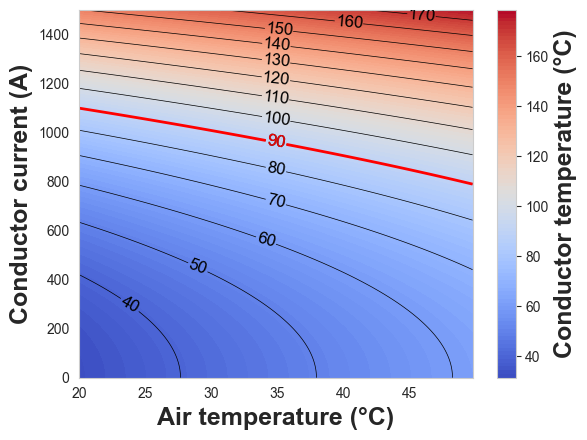

In [75]:
current_list = np.arange(0, 1500, 0.5)
tem_air_list = np.arange(20, 50, 0.2)

w = ieee_weather.copy()
tem_con_list = []
for t_air in tem_air_list:
    w['air_temperature'] = t_air
    tem_con_list.append(
        heat_banlance_equation(current_list, ieee_conductor, w)
    )
tem_con_list = np.stack(tem_con_list, axis=1)

x, y = np.meshgrid(tem_air_list, current_list)

fig, ax = plt.subplots(figsize=(6, 4.5))
contourf = ax.contourf(x, y, tem_con_list, 100, cmap='coolwarm')

# Temperature isolines
levels = np.arange(0, 200, 10)
contour = ax.contour(x, y, tem_con_list, levels=levels,
                     colors='black', linewidths=0.5)
ax.clabel(contour, inline=True, fontsize=12, fmt='%1.0f',
          inline_spacing=3, rightside_up=True,
          manual=get_contour_label_positions(contour))

# Thermal-limit highlight
contour_90 = ax.contour(x, y, tem_con_list, levels=[90],
                        colors='red', linewidths=2)
ax.clabel(contour_90, inline=True, fontsize=12, fmt='%1.0f',
          inline_spacing=3, rightside_up=True,
          manual=get_contour_label_positions(contour_90))

cbar = fig.colorbar(contourf, ax=ax)
cbar.set_ticks(np.arange(40, 170, 20))
cbar.set_label('Conductor temperature (°C)', fontsize=18, fontweight='bold')
ax.set_xlabel('Air temperature (°C)', fontsize=18, fontweight='bold')
ax.set_ylabel('Conductor current (A)', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig(MODELS + '/thermal_analysis/ieee_tem_air_current.png',
            dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Wind Speed × Wind–Conductor Angle → Conductor Temperature

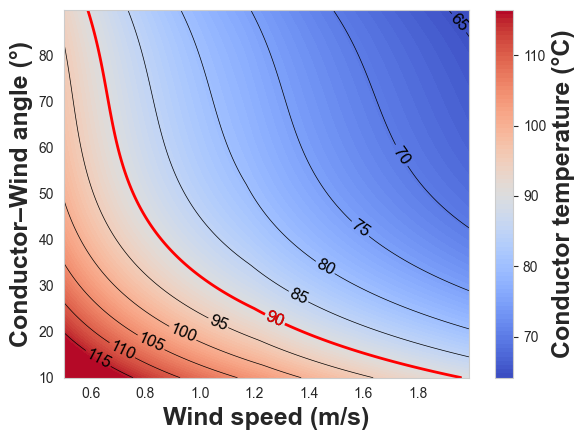

In [78]:
wind_speed_list = np.arange(0.5, 2, 0.01)
angle_diff_list = np.arange(10, 90, 0.1)
current = 1000  # A (nominal)

w = ieee_weather.copy()
w['wind_angle'] = angle_diff_list
w['air_temperature'] = 30

tem_con_list = []
for ws in wind_speed_list:
    w['wind_speed'] = ws
    tem_con_list.append(
        heat_banlance_equation(current, ieee_conductor.copy(), w.copy())
    )
tem_con_list = np.stack(tem_con_list, axis=1)

x, y = np.meshgrid(wind_speed_list, angle_diff_list)

fig, ax = plt.subplots(figsize=(6, 4.5))
contourf = ax.contourf(x, y, tem_con_list, 100, cmap='coolwarm')

levels = np.arange(0, 120, 5)
contour = ax.contour(x, y, tem_con_list, levels=levels,
                     colors='black', linewidths=0.5)
ax.clabel(contour, inline=True, fontsize=12, fmt='%1.0f',
          inline_spacing=3, rightside_up=True,
          manual=get_contour_label_positions(contour))

contour_90 = ax.contour(x, y, tem_con_list, levels=[90],
                        colors='red', linewidths=2)
ax.clabel(contour_90, inline=True, fontsize=12, fmt='%1.0f',
          inline_spacing=3, rightside_up=True,
          manual=get_contour_label_positions(contour_90))

cbar = fig.colorbar(contourf, ax=ax)
cbar.set_ticks(np.arange(70, 120, 10))
cbar.set_label('Conductor temperature (°C)', fontsize=18, fontweight='bold')
ax.set_xlabel('Wind speed (m/s)', fontsize=18, fontweight='bold')
ax.set_ylabel('Conductor–Wind angle (°)', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig(MODELS + '/thermal_analysis/ieee_tem_wind_angle.png',
            dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Air Temperature × Wind Speed → Maximum Allowable Current

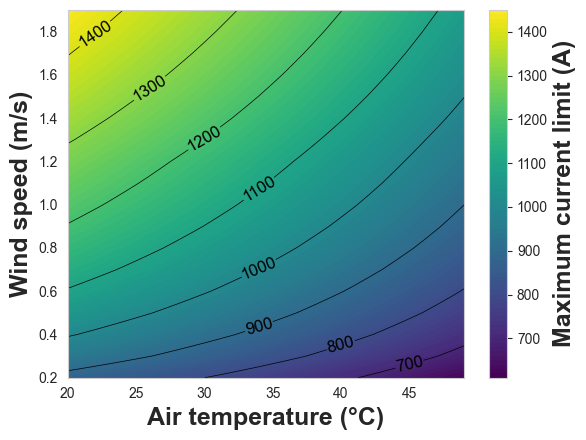

In [83]:
tem_air_list = np.arange(20, 50)
wind_speed_list = np.arange(0.2, 2, 0.1)

w = ieee_weather.copy()
w['wind_speed'] = wind_speed_list

I_max_list = []
for t_air in tem_air_list:
    w['air_temperature'] = t_air
    I_max_list.append(
        maximum_allowable_current(ieee_conductor.copy(), w.copy())
    )
I_max_list = np.stack(I_max_list, axis=1)

x, y = np.meshgrid(tem_air_list, wind_speed_list)

fig, ax = plt.subplots(figsize=(6, 4.5))
contourf = ax.contourf(x, y, I_max_list, 100, cmap='viridis')

levels = np.arange(0, 2000, 100)
contour = ax.contour(x, y, I_max_list, levels=levels,
                     colors='black', linewidths=0.5)
ax.clabel(contour, inline=True, fontsize=12, fmt='%1.0f',
          inline_spacing=3, rightside_up=True,
          manual=get_contour_label_positions(contour))

cbar = fig.colorbar(contourf, ax=ax)
cbar.set_ticks(np.arange(700, 1500, 100))
cbar.set_label('Maximum current limit (A)', fontsize=18, fontweight='bold')
ax.set_xlabel('Air temperature (°C)', fontsize=18, fontweight='bold')
ax.set_ylabel('Wind speed (m/s)', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig(MODELS + '/thermal_analysis/ieee_current_wind_air.png',
            dpi=300, bbox_inches='tight')
plt.show()

## 5. Quadratic Approximation Error

Compare the exact heat-balance solution `T*` with the quadratic
approximation `T_qua` at three wind-speed levels.  The scatter colour
indicates the error `T* − T_qua` (°C).

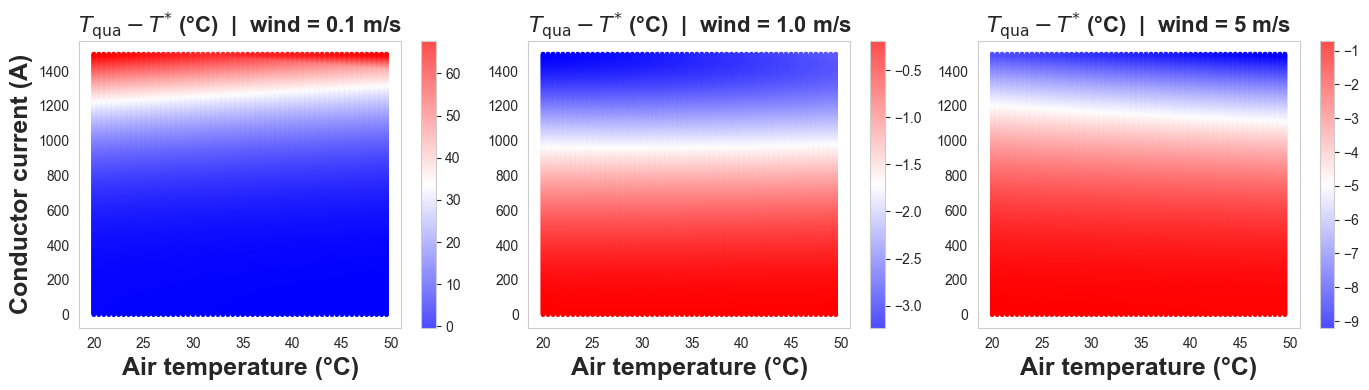

In [88]:
w = ieee_weather.copy()

fig = plt.figure(figsize=(14, 4))

for i, wind in enumerate([0.1, 1.0, 5]):
    w['wind_speed'] = wind
    current_list = np.arange(0, 1500, 1)
    tem_air_list = np.arange(20, 50, 0.5)

    # Exact solution
    tem_exact = []
    for t_air in tem_air_list:
        w['air_temperature'] = t_air
        tem_exact.append(
            heat_banlance_equation(current_list, ieee_conductor, w)
        )
    tem_exact = np.stack(tem_exact, axis=1)

    # Quadratic approximation
    tem_quad = []
    for t_air in tem_air_list:
        w['air_temperature'] = t_air
        tem_quad.append(
            quadratic_heat_balance_approximation(
                current_list, ieee_conductor, w)
        )
    tem_quad = np.stack(tem_quad, axis=1)

    x, y = np.meshgrid(tem_air_list, current_list)

    ax = fig.add_subplot(1, 3, i + 1)
    sc = ax.scatter(x, y, c=(tem_quad - tem_exact),
                    cmap='bwr', alpha=0.7, s=5)
    ax.set_xlabel('Air temperature (°C)', fontsize=18, fontweight='bold')
    if i == 0:
        ax.set_ylabel('Conductor current (A)', fontsize=18, fontweight='bold')
    ax.set_title(
        r'$T_{\mathrm{qua}}-T^{*}$ (°C)'
        + f'  |  wind = {wind} m/s', fontsize=16, fontweight='bold'
    )
    plt.colorbar(sc, ax=ax)
    plt.grid(alpha=0)
    plt.tight_layout()

fig.tight_layout()
plt.savefig(MODELS + '/thermal_analysis/ieee_quadratic_error_wind.png',
            dpi=300, bbox_inches='tight')
plt.show()

## 6. Comparison Plots — IEEE Drake ACSR

In [92]:
# save_dir = MODELS + '/thermal_analysis/ieee_comparison/'
# os.makedirs(save_dir, exist_ok=True)

# fig1, _ = plot_current_vs_air_temp(
#     conductor=ieee_conductor.copy(), weather=ieee_weather.copy(),
#     save_path=save_dir + 'current_vs_air_temp.pdf',
# )
# fig2, _ = plot_max_current_vs_conditions(
#     conductor=ieee_conductor.copy(), weather=ieee_weather.copy(),
#     save_path=save_dir + 'max_current_vs_conditions.pdf',
# )
# fig3, _ = plot_temp_vs_conditions_at_nominal(
#     conductor=ieee_conductor.copy(), weather=ieee_weather.copy(),
#     save_path=save_dir + 'temp_vs_conditions_at_nominal.pdf',
# )

## 7. Comparison Plots — European Per-Sub-Conductor

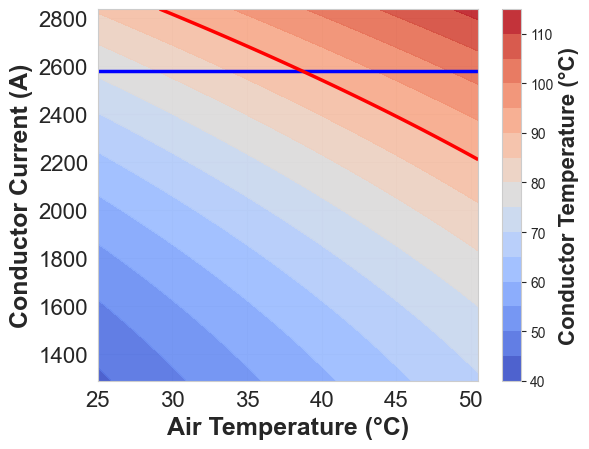

In [93]:
save_dir = MODELS + '/thermal_analysis/eu_single/'
os.makedirs(save_dir, exist_ok=True)

fig1, _ = plot_current_vs_air_temp(
    conductor=european_conductor_single.copy(),
    weather=european_weather.copy(),
    save_path=save_dir + 'current_vs_air_temp.pdf',
)
# fig2, _ = plot_max_current_vs_conditions(
#     conductor=european_conductor_single.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'max_current_vs_conditions.pdf',
# )
# fig3, _ = plot_temp_vs_conditions_at_nominal(
#     conductor=european_conductor_single.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'temp_vs_conditions_at_nominal.pdf',
# )

## 8. Comparison Plots — European With Correction Factors

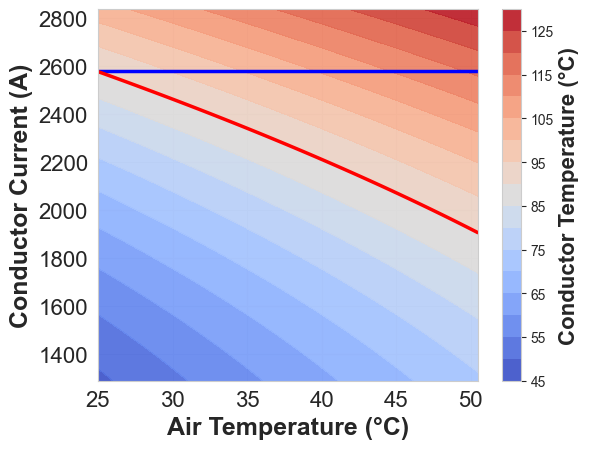

In [94]:
save_dir = MODELS + '/thermal_analysis/eu_single_corr/'
os.makedirs(save_dir, exist_ok=True)

fig1, _ = plot_current_vs_air_temp(
    conductor=european_conductor_corrected.copy(),
    weather=european_weather.copy(),
    save_path=save_dir + 'current_vs_air_temp.pdf',
)
# fig2, _ = plot_max_current_vs_conditions(
#     conductor=european_conductor_corrected.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'max_current_vs_conditions.pdf',
# )
# fig3, _ = plot_temp_vs_conditions_at_nominal(
#     conductor=european_conductor_corrected.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'temp_vs_conditions_at_nominal.pdf',
# )

## 9. Comparison Plots — European Merged Equivalent

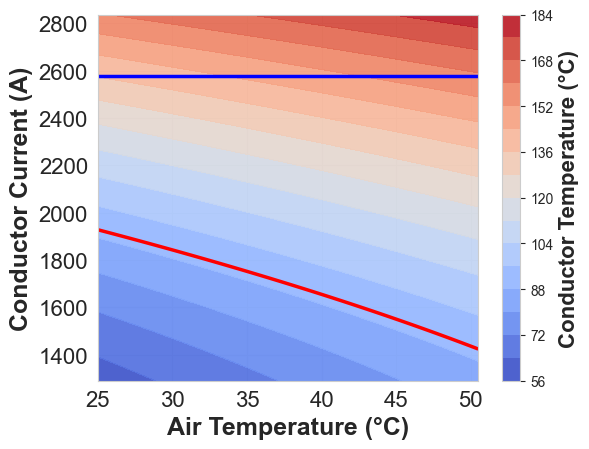

In [95]:
save_dir = MODELS + '/thermal_analysis/eu_merge/'
os.makedirs(save_dir, exist_ok=True)

fig1, _ = plot_current_vs_air_temp(
    conductor=european_conductor_merge.copy(),
    weather=european_weather.copy(),
    save_path=save_dir + 'current_vs_air_temp.pdf',
)
# fig2, _ = plot_max_current_vs_conditions(
#     conductor=european_conductor_merge.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'max_current_vs_conditions.pdf',
# )
# fig3, _ = plot_temp_vs_conditions_at_nominal(
#     conductor=european_conductor_merge.copy(),
#     weather=european_weather.copy(),
#     save_path=save_dir + 'temp_vs_conditions_at_nominal.pdf',
# )

## 10. Standalone Legends

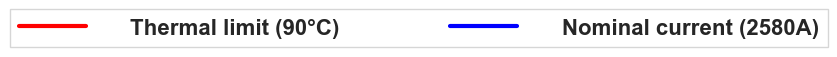

In [96]:
# Wide legend (for appendix / multi-panel figures)
fig, ax = plt.subplots(figsize=(6, 0.1))
legend = ax.legend(
    handles=[
        mlines.Line2D([], [], color='red', linewidth=3,
                       label='Thermal limit (90°C)'),
        mlines.Line2D([], [], color='blue', linewidth=3,
                       label='Nominal current (2580A)'),
    ],
    loc='center', ncol=2, columnspacing=5.0, fontsize=16,
    frameon=True, fancybox=False, handlelength=3.0, handletextpad=2,
)
for t in legend.texts:
    t.set_fontweight('bold')
ax.axis('off')
plt.savefig(
    MODELS + '/thermal_analysis/legend.pdf',
    format='pdf', dpi=300, bbox_inches='tight',
)
plt.show()

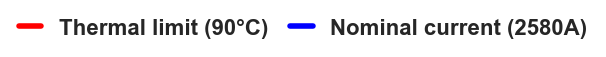

In [70]:
# Compact legend (for main text)
fig, ax = plt.subplots(figsize=(6, 0.1))
legend = ax.legend(
    handles=[
        mlines.Line2D([], [], color='red', linewidth=4,
                       label='Thermal limit (90°C)'),
        mlines.Line2D([], [], color='blue', linewidth=4,
                       label='Nominal current (2580A)'),
    ],
    loc='center', ncol=2, columnspacing=1.0, fontsize=16,
    frameon=False, fancybox=False, handlelength=1.0, handletextpad=0.8,
)
for t in legend.texts:
    t.set_fontweight('bold')
ax.axis('off')
plt.savefig(
    MODELS + '/thermal_analysis/legend_main.pdf',
    format='pdf', dpi=300, bbox_inches='tight',
)
plt.show()

## 11. Generator Derating Curves

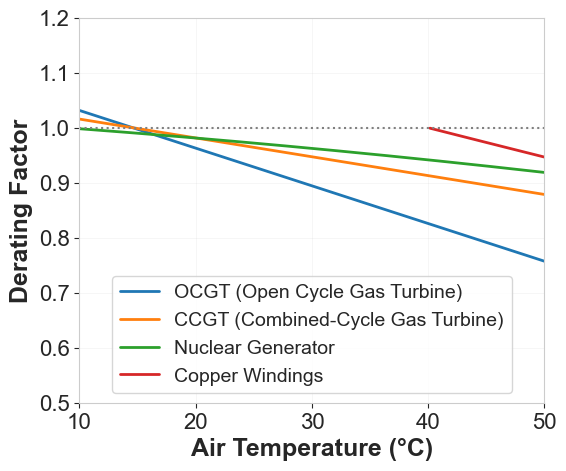

In [97]:
tem_air = np.linspace(10, 50, 200)

derating_ocgt = (-0.6854 * tem_air + 110) / 100
derating_ccgt = (-0.6854 * tem_air / 2 + 105) / 100
derating_nuclear = (101.3042 - 0.1387 * tem_air - 0.0010 * tem_air ** 2) / 100
derating_copper = (
    ((180 - tem_air) * (1 + 0.0039 * (40 - 20)))
    / ((180 - 40) * (1 + 0.0039 * (tem_air - 20)))
) ** 0.5

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(tem_air, derating_ocgt, linewidth=2,
        label='OCGT (Open Cycle Gas Turbine)')
ax.plot(tem_air, derating_ccgt, linewidth=2,
        label='CCGT (Combined-Cycle Gas Turbine)')
ax.plot(tem_air, derating_nuclear, linewidth=2,
        label='Nuclear Generator')
ax.plot(tem_air[tem_air > 40], derating_copper[tem_air > 40], linewidth=2,
        label='Copper Windings')
ax.plot(tem_air, np.ones_like(tem_air), linewidth=1.5,
        linestyle=':', color='gray')

ax.set_xlabel('Air Temperature (°C)', fontsize=18, fontweight='bold')
ax.set_ylabel('Derating Factor', fontsize=18, fontweight='bold')
ax.legend(fontsize=14, loc='lower center', frameon=True, columnspacing=1.5)
ax.set_xlim(10, 50)
ax.set_ylim(0.5, 1.2)
ax.set_xticks([10, 20, 30, 40, 50])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(
    axis='both', which='both',
    top=False, bottom=True, left=True, right=False,
)
ax.grid(linewidth=0.5, alpha=0.25)

plt.savefig(
    MODELS + '/thermal_analysis/derating_curves.pdf',
    format='pdf', dpi=300, bbox_inches='tight',
)
plt.show()